In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%run dataset/pycoco_split.py

In [34]:
#Define out detector CNN model
class HumanDetectorCNN(nn.Module):
    def __init__(self):
        super(HumanDetectorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [35]:
# Data Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the MSCoCo dataset
dataset = datasets.ImageFolder(root="dataset/val2017", transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [59]:
# Initialize the model
model = HumanDetectorCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
loss_tracker = {}
accuracy_tracker = {}
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataset:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(0))
        loss = criterion(outputs, torch.tensor([labels]))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Print loss every epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataset)}")
    loss_tracker[str(epoch + 1)] = running_loss / len(train_dataset)

    # Evaluate the model every 5th epoch
    if (epoch + 1) % 5 == 0:
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_dataset:
                outputs = model(inputs.unsqueeze(0))
                _, predicted = torch.max(outputs, 1)
                total += 1
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Accuracy: {accuracy}")
        accuracy_tracker[str(epoch + 1)] = accuracy

Epoch 1, Loss: 0.6869357319576666
Epoch 2, Loss: 0.6661530477388297
Epoch 3, Loss: 0.6440660910068545
Epoch 4, Loss: 0.6075472707179143
Epoch 5, Loss: 0.5397339843233222
Accuracy: .592
Epoch 6, Loss: 0.44934804005490875
Epoch 7, Loss: 0.3524777747992297
Epoch 8, Loss: 0.28619671730433177
Epoch 9, Loss: 0.22785941111358318
Epoch 10, Loss: 0.1941728944638245
Accuracy: .604
Epoch 11, Loss: 0.16990648722676469
Epoch 12, Loss: 0.17194979589578785
Epoch 13, Loss: 0.1355897866824301
Epoch 14, Loss: 0.11631697881715104
Epoch 15, Loss: 0.11875953502211191
Accuracy: .610
Epoch 16, Loss: 0.09149349099620371
Epoch 17, Loss: 0.08441249361979129
Epoch 18, Loss: 0.0731469447537604
Epoch 19, Loss: 0.06827111974229279
Epoch 20, Loss: 0.06973755052742461
Accuracy: .628
Epoch 21, Loss: 0.06473502941626867
Epoch 22, Loss: 0.06803978985296813
Epoch 23, Loss: 0.0712801420105041
Epoch 24, Loss: 0.05363433721278882
Epoch 25, Loss: 0.043057720512610365
Accuracy: .617
Epoch 26, Loss: 0.058363482007606125
Epoch 

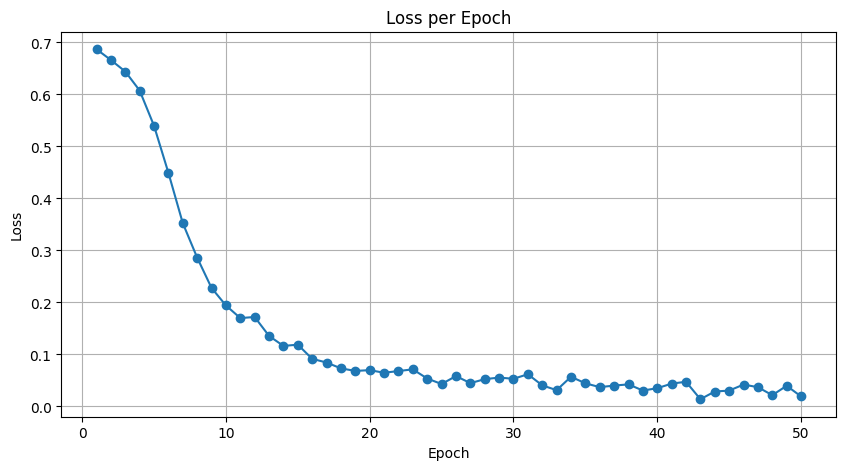

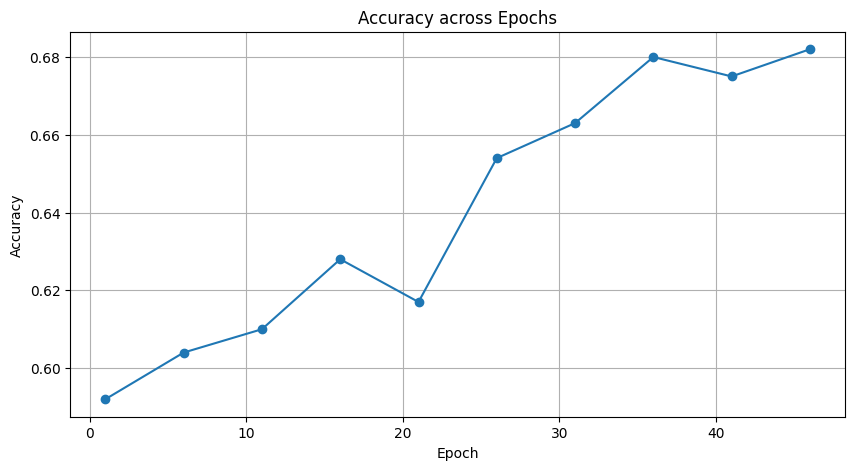

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), loss_tracker.values(), marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_per_epoch.png')


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1, 5), accuracy_tracker.values(), marker='o')
plt.title('Accuracy across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('accuracy_per_epoch.png')